## _*H2 ground state energy with VQE and SPSA*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using VQE with SPSA optimizer. It is compared to the same energies as computed by the ExactEigensolver. SPSA is designed to work well with probabalistic/noisy measurements. And with RYRZ variational form makes this a suitable configuration to run on a near term device.

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType, TransformationType

molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = [{'name': 'VQE'},
              {'name': 'ExactEigensolver'}
             ]

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

aqua_globals.random_seed = 750

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    for j in range(len(algorithms)):
        driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(transformation=TransformationType.FULL,
                                qubit_mapping=QubitMappingType.PARITY, two_qubit_reduction=True)
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j]['name'] == 'VQE':
            optimizer = SPSA(max_trials=200)
            var_form = RYRZ(qubit_op.num_qubits, depth=3, entanglement='full')
            algo = VQE(qubit_op, var_form, optimizer)
            result = algo.run(QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                seed_simulator=aqua_globals.random_seed,
                                seed_transpiler=aqua_globals.random_seed,
                                shots=1024))
        else:
            result = ExactEigensolver(qubit_op).run()
            
        lines, result = operator.process_algorithm_result(result)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

Couldn't find cython int routine
Couldn't find cython int routine
Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.06086904 -1.07823595 -1.08939864 -1.10845548 -1.12428718 -1.13013638
  -1.13859574 -1.13654965 -1.13892688 -1.13872716 -1.13571941 -1.14315925
  -1.13378843 -1.13130389 -1.12723816 -1.12263038 -1.11777674 -1.1172618
  -1.11107348 -1.10808027 -1.10143207]
 [-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601 -1.12416092
  -1.12990478 -1.13382622 -1.13618945 -1.13722138 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133942 -1.10634211 -1.10115033]]
Hartree-Fock energies: [-1.04299627 -1.06306214 -1.07905074 -1.0915705  -1.10112824 -1.10814999
 -1.11299655 -1.11597526 -1.11734903 -1.11734327 -1.11615145 -1.11393966
 -1.1108504  -1.10700581 -1.10251055 -1.09745432 -1.09191404

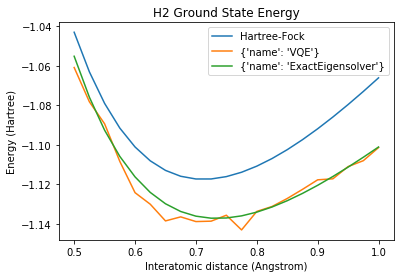

In [2]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance (Angstrom)')
pylab.ylabel('Energy (Hartree)')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right');

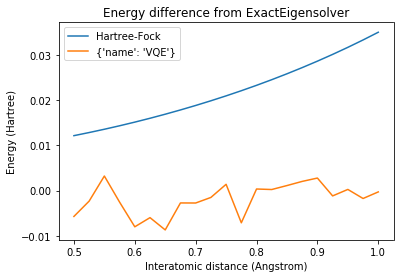

In [3]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label=algorithms[0])
pylab.xlabel('Interatomic distance (Angstrom)')
pylab.ylabel('Energy (Hartree)')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper left');